### Podatkovno rudarjenje, 2. domača naloga, 4. 4. 2018

# Iskanje strukture v podatkih

**Ime in priimek** **VPIŠI !!!**

Z modeliranjem skušamo poiskati strukturo v podatkih. Z metodami nenadzorovanga modeliranja skušamo poiskati skupine podobnih podatkov oz. skupine primerov.

V nalogi boste uporabili modeliranje verjetnostnih porazdelitev za iskanje osamelcev ter metode za iskanje skupin podobnih primerov (gručenje).

## Podatki

Opis podatkovne zbirke MovieLens ostaja enak prvi nalogi.

## Vprašanja

Z uporabo principov, ki ste jih spoznali na vajah in predavanjih, odgovorite na
spodnja vprašanja. Pri vsakem vprašanju dobro premislite, na kakšen način boste
najbolje podali, prikazali oz. utemeljili odgovor. Bistven del so odgovori na
vprašanja in ne toliko implementacija vaše rešitve.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from scipy.stats import t as student 
from scipy.stats import multivariate_normal as mvn 
from scipy.stats import beta
from scipy import stats

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import scipy.cluster.hierarchy as sch
import scipy

In [5]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')

### 1. Iskanje osamelcev (50%) 
O ocenah katerih filmov so si uporabniki najmanj enotni? Povedano drugače, za katere filme so pripadajoče ocene najbolj razpršene?

Formuliraj problem kot modeliranje verjetnostne porazdelitve. Premisli o naslednjih vprašanjih, naredi ustrezne poizkuse in odgovori.

### 1.1. vprašanje:

Katera je ustrezna naključna spremenljivka (količina) v podatkih, ki odgovarja na vprašanje?        

Odgovor: Standardni odklon ocen filmov (rating).

In [6]:
st_dev = np.var(ratings['rating'])
print("Standardni odklon je {}".format(st_dev))

Standardni odklon je 1.1194884644323722


### 1.2. vprašanje:
Nariši njeno porazdelitev, npr., s pomočjo histograma.

Odgovor: Naprej filme grupiram po id-ju. Nato za vsak film, ki ima 5 ali več ocen, izračunam standardni odklon njegovih ocen.

In [7]:
# groups by movieId and then 
groups = ratings.groupby(["movieId"], as_index=False)
sample = []
sample_dict = dict() # uporabljen v tocki 1.5
for e in groups:
    if len(e[1]) >= 5:
        v = np.nanstd(e[1]["rating"])
        k = e[1]["movieId"]
        k = int(k.head(1))
        sample_dict[k] = v
        sample.append(v)

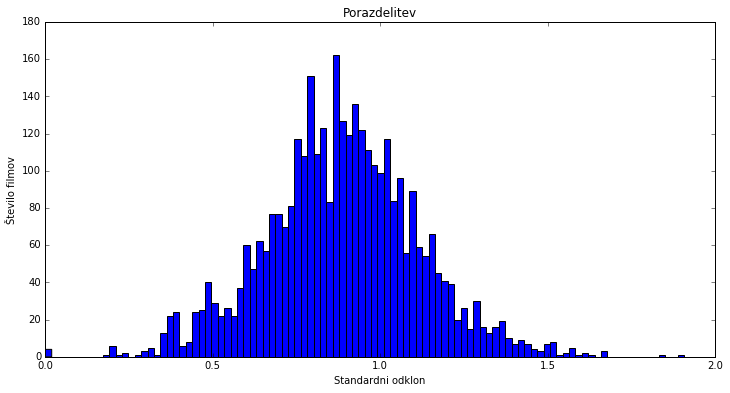

In [8]:
plt.figure(figsize=(12, 6));
plt.title("Porazdelitev");
plt.hist(sample, normed=False, bins=100);
plt.xlabel("Standardni odklon");
plt.ylabel("Število filmov");

### 1.3. vprašanje:

Ali porazdelitev spominja na kakšno znano porazdelitev? Ali je porazdelitev morda normalna ali katera druga? 

Odgovor: Oblika porazdelitve spominja na normalno porazdelitev.

### 1.4. vprašanje:

Oceni parametre te porazdelitve s pomočjo postopkov, ki smo jih spoznali na vajah.  Izmed porazdelitev, ki smo jih spoznali na vajah, izberi tisto, ki se podatkom najbolj prilega.        

In [9]:
xr = np.linspace(0, 2, 100)  # interval X 

In [10]:
# Student t
pars = student.fit(sample)
P_fit_student = [student.pdf(x, *pars) for x in xr ]

In [11]:
# Normal
n = len(sample)
mu_fit = np.mean(sample)
sigma2_fit = (n-1)/n * np.var(sample)
P_fit_normal = [mvn.pdf(x, mu_fit, sigma2_fit) for x in xr]

In [12]:
# Beta
parameters = beta.fit(sample);
P_fit_beta = [beta.pdf(x, *parameters) for x in xr];

C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


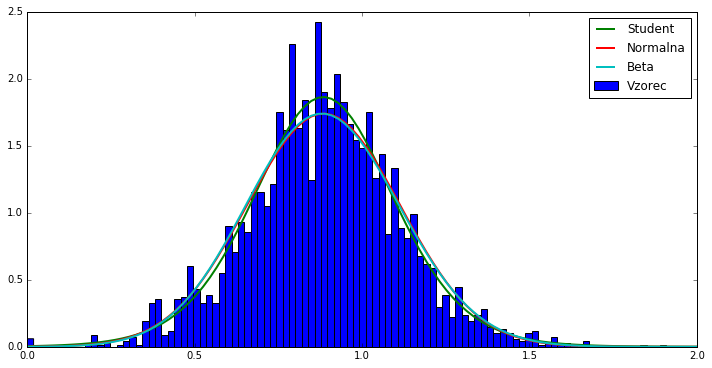

In [13]:
plt.figure(figsize=(12, 6));
plt.xlim((0, 2)) 
plt.hist(sample,    label="Vzorec", bins=100, normed=True)
plt.plot(xr, P_fit_student, label="Student", linewidth=2.0)
plt.plot(xr, P_fit_normal, label="Normalna", linewidth=2.0)
plt.plot(xr, P_fit_beta, label="Beta", linewidth=2.0)
plt.legend();

Odgovor: Studentova porazdelitev se najbolj prilega podatkom.

### 1.5. vprašanje:

Izpiši filme z vrednostjo naključne spremenljivke, ki spada v zgornjih 5% statistično značilnih primerov. 

In [14]:
value = stats.t(df=pars[0]).ppf(0.95)
movie_ids = [k for k,v in sample_dict.items() if v >= value]
movies[movies["movieId"].isin(movie_ids)]

,movieId,title,genres
1875,2365,King Kong vs. Godzilla (Kingukongu tai Gojira)...,Action|Sci-Fi
3179,3973,Book of Shadows: Blair Witch 2 (2000),Crime|Horror|Mystery|Thriller


Odgovor: Najprej sem dobil 95. percentil ocenjene Studentove porazdelitve. Nato sem izpisal vse vrednosti, ki so večje od vrednosti 95. percentila. Upoštevani so filmi, ki imajo 5 ali več ocen.

### 2. Gručenje filmov (50%)

Priporočilni sistemi pogosto odkrivajo skupine predmetov (v našem primeru filme), za katere velja visoka podobnost. 

Poiščite 100 najbolj gledanih filmov. Ali med njimi obstajajo skupine?
Uporabite ustrezen algoritem za gručenje. Na film lahko gledamo kot vektor, kjer je  
število komponent enako številu uporabnikov. 

Vektorji vsebujejo tudi *neznane vrednosti*.
Primer vektorjev za deset filmov prikazuje spodnja tabela.

Algoritme gručenja lahko izvajamo v izvornem prostoru (koordinatni sistem filmi-uporabniki) ali pa filme primerjamo z merami podobnosti, ki smo jih spoznali na vajah. 
Premisli, kateri način je primernejši glede na obliko podatkov.

| x          |Movie                                      | $u_0$ |$u_1$ | $u_2$ | $\cdots$ |
|------------|-------------------------------------------|:-----:|:----:|:------|:--------:|
|$\vec{x_0}$ | Fight Club (1999)                         | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_1}$ | Twelve Monkeys (a.k.a. 12 Monkeys) (1995) | ?     | ?    | 2.5   | $\cdots$ |
|$\vec{x_2}$ | Independence Day (a.k.a. ID4) (1996)      | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_3}$ | Dances with  Wolves (1990)                | 4.0   | ?    | ?     | $\cdots$ |
|$\vec{x_4}$ | Fargo (1996)                              | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_5}$ | Speed (1994)                              | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_6}$ | Apollo 13 (1995)                          | ?     | 2.0  | ?     | $\cdots$ |
|$\vec{x_7}$ | Seven (a.k.a. Se7en) (1995)               | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_8}$ | Sixth Sense, The (1999)                   | 3.0   | ?    | 4.0   | $\cdots$ |
|$\vec{x_9}$ | Aladdin (1992)                            | ?     | ?    | ?     | $\cdots$ |
|$\cdots$    | $\cdots$                                  | $\cdots$ | $\cdots$  | $\cdots$ | $\cdots$ |

Pri tem odgovori na naslednja vprašanja.

In [15]:
columns = ["name"]
columns += list(np.unique(ratings["userId"]))
grouped_df = ratings.groupby(["movieId"], as_index=False).agg({"rating": np.size})
grouped_df.columns = ["movieId", "count"]  
grouped_df = grouped_df.sort_values(by=['count'], ascending=False)
indices = grouped_df[:100]["movieId"]

In [16]:
movie_ratings = pd.DataFrame(columns=columns)
grouped_df = ratings.groupby(["movieId"], as_index=False)
for i in indices:
    group = grouped_df.get_group(i)[["userId", "rating"]]
    columns = ["name"]
    columns += list(group["userId"])
    df = pd.DataFrame(columns=columns)

    #data = list(group["name"])
    #data = [data[0]]
    data = movies[movies["movieId"] == i]["title"].tolist()
    data += list(group["rating"])
    df.loc[df.size + 1] = data
    movie_ratings = movie_ratings.append(df);
    
# Nan vrednosti zamanja z -1
movie_ratings = movie_ratings.fillna(-1)

### 2.1. vprašanje:

Utemelji izbiro algoritma in mere podobnosti.

Odgovor: Uporabil sem hierarhično gručenje, ker ne vemo koliko gruč je v podatkih. Za mero podobnosti sem najprej uporabil Jaccardov indeks, ker so v matriki manjkajoči podatki, ampak se ni izkazal kot najboljši. Zato sem poskusil ostale 3 mere in sem uporabil Evklidsko razdaljo, ker je vrnila najboljše rezultate. 

In [17]:
L = sch.linkage(np.array(movie_ratings.loc[:, movie_ratings.columns != "name"]), method="average", metric="euclidean")

In [18]:
t = 68
predictions = sch.fcluster(L, t=t, criterion="distance").ravel()
number_of_groups = np.unique(predictions).size
print("Število skupin: {}".format(number_of_groups))

Število skupin: 16


### 2.2. vprašanje:

Koliko skupin filmov je med izbranimi? Ali poznamo kvantitativne ocene za različne možnosti razvrščanja v skupine?

Odgovor: Skupne deljene informacije ne poznamo, ker nimamo resničnih vrednosti razredov. Koeficient silhuete lahko izračunamo. 

### 2.3. vprašanje:

Prikaži rezultate z uporabo ustrezne vizualizacije.

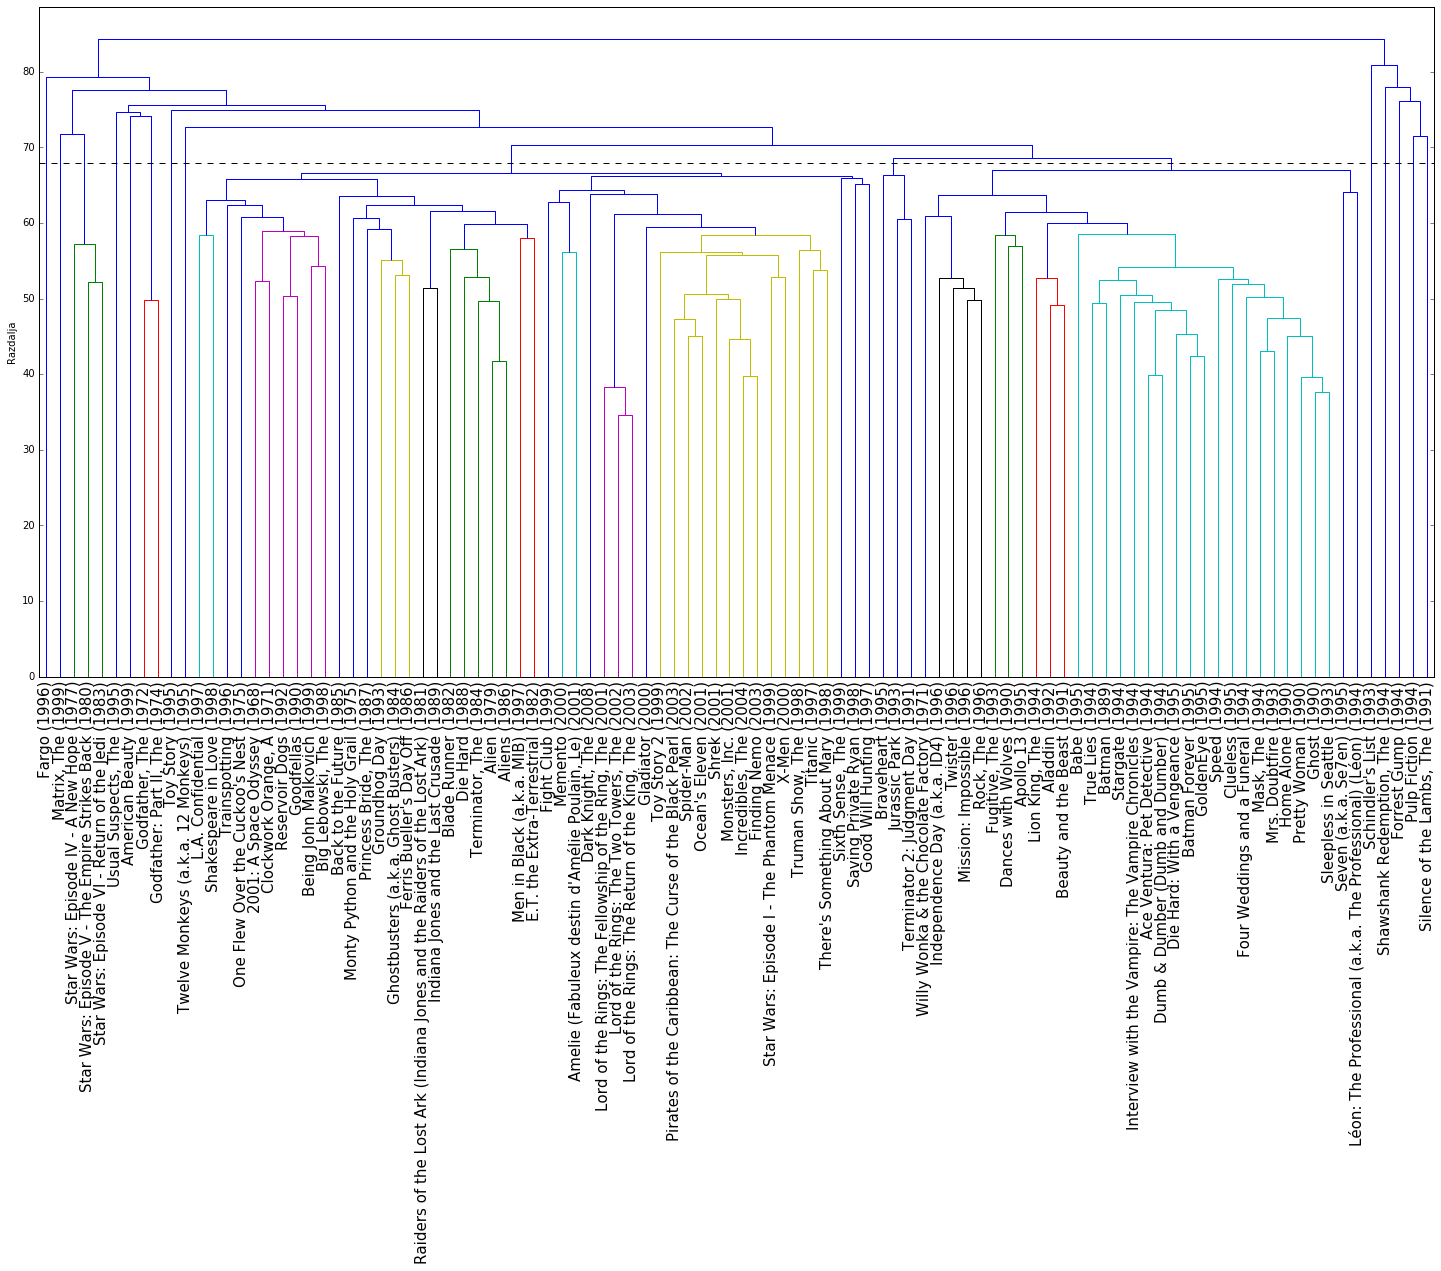

In [19]:
plt.figure(figsize=(25, 12))
labels = [row for row in movie_ratings["name"]]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.plot([0, 1000], [t, t], "k--")
plt.ylabel("Razdalja")
plt.show()

Odgovor: Najbolj ustrezna vizualizacija za hierarhično gručenje je dendrogram.

### 2.4. vprašanje:

Komentiraj smiselnost dobljenih rezultatov.

Se mi zdi, da so rezultati smiselni, ker je algoritem ustvaril gruče filmov Godfather 1 in 2, Disney-eve risanke, Star Wars, Indiana Jones, žanra triler, animirane filme in podobno. 

Odgovor: **odgovor lahko zapišete v več celic**